In [1]:
# connects colab to drive
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/AA/Code')

Mounted at /content/drive


# Source Separation

In [ ]:
!pip3 install spleeter

In [ ]:
import os
def find(path='/content/drive/My Drive/AA/Music dataset/Tonic_Source_Separation',name = 'accompaniment.mp3'):
    for root, dirs, files in os.walk(path):
        if name in files:
            os.remove(os.path.join(root, name))

In [ ]:
from spleeter.separator import Separator
path = '/content/drive/My Drive/AA/Music dataset/tonic_dataset_og/{}'
# import os


all_songs = os.listdir('/content/drive/My Drive/AA/Music dataset/tonic_dataset_og/')
all_songs.sort()
done = os.listdir('/content/drive/My Drive/AA/Music dataset/Tonic_Source_Separation/')

for i in all_songs[len(done)+1:]:
  separator.separate_to_file(path.format(i), '/content/drive/My Drive/AA/Music dataset/Tonic_Source_Separation',codec = 'mp3',duration = 10000)
  find()
  print("song: ",i)


# Main Class

In [17]:
import librosa
import librosa.display
from swipe import *
from scipy import signal
import scipy
import math
from collections import defaultdict, OrderedDict
import statistics
import copy
import json
import os
plt.rcParams['figure.figsize'] = [20,5]
# defining the class 
# each object of this class is an audio clip that is to be analysed
class Audio:
  def __init__(self, path, sr=None, duration = None,tonic = None, songname = None): 
    # loading the audio file
    saved_features = os.listdir("/content/drive/My Drive/AA/Features/")
    if songname == None:
      self.songname = path.split("/")[-2]
    else: 
      self.songname = songname
    if self.songname +".json" in saved_features:
      with open('/content/drive/My Drive/AA/Features/{}.json'.format(self.songname)) as x:
        features = json.load(x)
      self.__dict__ = features
    else:
      self.x, self.sr1 = librosa.load(path= path, sr=sr,duration=duration)
      self.pitch_contour()
      self.constant_pitch()
      self.find_gamaka()
      self.find_stationary_points()
      if tonic ==None:
        self.tonic = self.find_tonic(path)
      else:
        self.tonic = tonic
      self.normalize()
      self.develop_histogram(cpn = False)
      self.histogram()
      self.find_all_notes()
      self.sequence_notes = self.find_sequence_notes(parameter = self.all_notes)
      self.pattern=self.find_pattern()
      self.save_features()
  # computing pitch contour
  def pitch_contour(self,dt = 0.01):
    self.pitch, self.time_axis, self.s = swipe(self.x,self.sr1,[100, 500],dt, 0.4)
    
  def constant_pitch(self ):
    
    time_axis_80 = []
    pitch_80 = []
    constant_pitch_time_80=[]
  
    for i in range(0,len(self.time_axis),8):
      pitch_80.append(self.pitch[i])
      time_axis_80.append(self.time_axis[i])
    delta = 12
      
    diff_80 = np.diff(pitch_80)

    for i in range(len(diff_80)):
      # constant note when the slope(of the pitch contour) is within the thershold i.e, delta =  
      if(diff_80[i]<delta/2 and diff_80[i]>-delta/2):
        constant_pitch_time_80.append(time_axis_80[i])
    self.constant_pitch_time_80 = np.array(constant_pitch_time_80)

    cpt = list(self.constant_pitch_time_80.round(2))
    tim = []
    initial = cpt[0]
    c= initial
    for i in range(1,len(cpt)):
      check = round(cpt[i]-c,2)
      if(check == 0.08):
        pass
      else:
        tim.append((initial,c))
        initial = cpt[i]
      if i == (len(cpt)-1):
        c= cpt[i]
        tim.append((initial,c))
      c= cpt[i]
    ta = list(self.time_axis)
    self.cpn_and_t = []
    for i in tim:
      begin = int(100*i[0])
      end = int(100*i[1])
      self.cpn_and_t.append((self.pitch[begin:end],ta[begin:end]))
    self.cpn_and_t = np.array(self.cpn_and_t)
    g,h = self.cpn_and_t.T
    self.cpn = np.array([item for sublist in g for item in sublist])
    self.cpt = np.array([item for sublist in h for item in sublist])
  
  def find_all_notes(self):  
    self.all_notes = []
    for i in self.n_pitch:
      if i in self.n_cpn or i in self.n_stp:
        self.all_notes.append(i)

  def find_gamaka(self):
    ta = list(self.time_axis)
    self.bt_cpn = []
    self.bt_cpt = []
    init = 0
    for _,j in self.cpn_and_t:
      if(j):
        begin = int(100*init)
        end = int(100*j[0])
        temp = self.pitch[begin:end]
        self.bt_cpn.append(temp)
        self.bt_cpt.append(ta[begin:end])
        init = j[-1]

  def find_stationary_points(self):
    self.stp = []
    self.stp_t = []
    for i in range(len(self.bt_cpn)):
      test = self.bt_cpn[i]
      test_time  = self.bt_cpt[i]
      for i in signal.find_peaks(test)[0]:
        self.stp.append(test[i])
        self.stp_t.append(test_time[i])
      for i in signal.find_peaks(-1*test)[0]:
        self.stp.append(test[i])
        self.stp_t.append(test_time[i])
  def develop_histogram(self,cpn):
    if(cpn):
      d = list(self.cpn) + list(self.stp)
      values=[x for x in d if (math.isnan(x) == False)]
      initial = 120
      end = 500
      increment = 1
      r = 0
    else:
      values = [x for x in self.n_pitch if (math.isnan(x) == False)]
      initial = all_normalized_notes['lSa0']
      end = all_normalized_notes['hNi3']
      increment = 0.01
      r = 2
    # values.extend(self.stp)
    values=[round(x,r) for x in values]
    occur=dict()
    self.d_hist=defaultdict(int)
    for i in values:
      if(i in occur):
        occur[i]+=1;
      else:
        occur[i]=1;
    j=initial
    while(j<=end):
      # print(j)
      if(j in occur):
        self.d_hist[j]=occur[j]
        # times.append(occur[j])
      else:
        self.d_hist[j]=0
      j+=increment
      j = round(j,r)

  def find_tonic(self,path):
    songname = path.split('/')[-2]
    with open('/content/drive/My Drive/AA/Music dataset/compMusicDetails.json') as x:
      tonic_data = json.load(x)
    for i in tonic_data.values():
      try:
        temp = i['songname'].split('.mp3')[0]
        if temp ==songname:
          return i['Tonic']
      except KeyError as e:
        pass 

  def histogram(self):
    self.hist_bins,self.hist_y = np.array(list(self.d_hist.items())).T
    self.n_hist_y = self.hist_y/len(self.pitch)

  def normalize(self):
    self.n_pitch = [12*np.log2(i/self.tonic) for i in self.pitch]
    self.n_bt_cpn = []
    for i in self.bt_cpn:
      self.n_bt_cpn.append([12*np.log2(j/self.tonic) for j in i])
    self.n_stp = [12*np.log2(i/self.tonic) for i in self.stp]
    self.n_cpn = [12*np.log2(i/self.tonic) for i in self.cpn]
  
  def find_sequence_notes(self,parameter):
    # print(parameter)
    notes = []
    for k in parameter:
      # min = 40
      if k in self.n_cpn:
        a = 0.04
      else:
        a = 0.135
      for i,j in all_normalized_notes.items():
        if (math.isclose(j,k,abs_tol= a)):
          notes.append(i)
    # print(notes)
    set_note = []
    initial = notes[0]
    set_note.append(initial)
    for i in range(1,len(notes)):
      if (initial != notes[i]):
        initial = notes[i]
        set_note.append(initial)
    return set_note

  def find_pattern(self):
    def countme(l,sl):
      count =0
      for i in range(0,len(l)):
        a=l[i:i+len(sl)]
        if (a==sl):
          count+=1
      return(count)
    cnt=0
    pattern=dict()
    for sublen in range(3,int(4)):
      for i in range(0,len(self.sequence_notes)-sublen):
        sub = self.sequence_notes[i:i+sublen]
        if(len(set(sub))>1):
          cnt = countme(self.sequence_notes,sub)
          str1=""
          strsub=str1.join(sub)
          if cnt >= (4) and strsub not in pattern:
            pattern[strsub] = cnt
    return pattern
  
  def save_features(self):
    important_key = ['n_pitch','time_axis','n_bt_cpn','tonic','hist_bins','n_hist_y','all_notes','sequence_notes','pattern']
    srt = dict()
    for i in important_key:
      x = self.__dict__[i]
      print(x)
      if type(x) == type(np.array([])):
        x = list(x)
      srt[i] = x
    json_dump = json.dumps(srt)
    with open("/content/drive/My Drive/AA/Features/{}.json".format(self.songname), "w") as outfile: 
        outfile.write(json_dump) 
  def plot(self,**kwargs):
    for key,value in kwargs.items():
      if(key=='contour' and value):
        plt.plot(self.time_axis,self.n_pitch,label = 'Pitch Contour')
      if(key == 'cpn' and value):
        plt.plot(self.time_axis,self.n_pitch,c="#FF0000",label = 'Pitch Contour')
        plt.scatter(self.cpt,self.n_cpn,c='0',label = 'Constant Pitch')
      if(key =='stp' and value):
        plt.scatter(self.stp_t,self.n_stp,c='#00FF00',label = 'Stationary Points')
        # plt.plot(self.time_axis,self.n_pitch,c="#FF0000",label = 'Pitch Contour')
      if(key =='histogram' and value):
        plt.plot(self.hist_bins,  self.n_hist_y,label = "histogram")
      plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)


ratios = {'Sa0':1,'Ri1':16/15,'Ri2':9/8,'Ga2':6/5,'Ga3':5/4,'Ma1':4/3,'Ma2':17/12,'Pa0':3/2,'Da1':8/5,
          'Da2':5/3,'Ni2':9/5,'Ni3':15/8,'Sa2':2}
all_normalized_notes = dict()
for i,j in ratios.items():
  all_normalized_notes[i] = 12*np.log2(j)
  all_normalized_notes['l'+i] = 12*np.log2(0.5*j)
  all_normalized_notes['h'+i] = 12*np.log2(2*j)

del all_normalized_notes['lSa2']
del all_normalized_notes['hSa0']
all_normalized_notes = OrderedDict(sorted(all_normalized_notes.items(),key=lambda kv: kv[1]))

# Compare Class

In [ ]:
class Compare_Audio:

  def __init__(self,audio1,audio2):
    self.audio1=audio1
    self.audio2=audio2
    self.compare_tonic()
    self.compare_pattern()
    self.compare_histogram()
    self.compare_gamaka()
    # self.find_similarity_index()       

    # self.index = 0.1*((audio1.tonic -audio2.tonic)**2)+ 0.3*()

  def compare_tonic(self):
    normalizing_tonic_factor=90
    self.tonic_index=1-(abs(self.audio1.tonic - self.audio2.tonic))/normalizing_tonic_factor

    self.tonic_index

  def compare_pattern(self):
    compare1= list(self.audio1.pattern.keys())
    compare2= list(self.audio2.pattern.keys())

    unnormalized_ratio=0

    for i in compare1:
      if (i in compare2):
        unnormalized_ratio += 1
    self.pattern_index = (unnormalized_ratio)/(min(len(compare1),len(compare2)))

  def compare_gamaka(self):
    # if(len(self.audio1.bt_cpn)>len(self.audio2.bt_cpn)):
    #   longer = self.audio1.bt_cpn
    #   shorter = self.audio2.bt_cpn
    # else:
    #   longer = self.audio2.bt_cpn
    #   shorter = self.audio1.bt_cpn
    # shorter=list(shorter)
    # longer=list(longer)
    # measures=[]
    # count=0
    # for i in longer:
    #   i=list(i)
    #   # i=[10000*g for g in i]
    #   i = [incom for incom in i if str(incom) != 'nan']
    #   measure=0
    #   for j in shorter:
    #     j=list(j)
    #     # j=[10000*g for g in j]
    #     j = [incom for incom in j if str(incom) != 'nan']
    #     if(len(i)>len(j)):
    #       for k in range(len(i)-len(j)):
    #         j.append(0)
    #     if(len(j)>len(i)):
    #       for k in range(len(j)-len(i)):
    #         i.append(0)
    #     cosine_similarity = 1 - scipy.spatial.distance.cosine(i,j)
    #     if(cosine_similarity>measure):
    #       count+=1
    #       measure = cosine_similarity
    #       # print("i and j :",i,j)
    #   measures.append(measure)
    # print("Measures :", measures)
    # print("Length and count :",len(longer), count)
    # self.gamaka_index= 1000**(0.1*(mean(measures))**9)-0.995262315
    self.gamaka_index = 1
  def compare_histogram(self):
    x = np.corrcoef([self.audio1.n_hist_y,self.audio2.n_hist_y])[0][1]
    self.histogram_index = (1/(1+3*np.exp(-9.5*(x-0.3))) , x)
  

  def find_similarity_index(self):
    self.similarity_index = (0.4*self.tonic_index + 10*self.pattern_index + 10*self.histogram_index )/10.4


In [ ]:
def validate (test_case):
  hist = {}
  tonic = {}
  pattern = {}
  gamaka = {}
  for i in test_case:
    hist[i.songname] = {}
    pattern[i.songname] = {}
    gamaka[i.songname] = {}
    for j in test_case:
      result = Compare_Audio(i,j)
      hist[i.songname][j.songname] = result.histogram_index
      pattern[i.songname][j.songname] = result.pattern_index
      gamaka[i.songname][j.songname] = result.gamaka_index
  return hist,pattern,gamaka

In [ ]:
sample = {"todi":["Aruna Sairam - Ninne Nammi.mp3"],"Madhyamavathi":["Hyderabad Brothers - Palinchu Kamakshi.mp3"],
 "Manji":["Nithyasree Mahadevan - Brovavamma.mp3"],
 "Reethigowla":["Aruna Sairam - Tatvamariya Tarama.mp3"],
 "Karaharapriya":["T. V. Sankaranarayanan - Chakkaniraja.mp3"],
 "same_ig":["Sanjay Subrahmanyan - Ragam Tanam Pallavi.mp3","Semmangudi Srinivasa Iyer - Ragam Tanam Pallavi.mp3"],
 "Bhairavi":[" - Varnam - Viriboni.mp3","M. D. Ramanathan - Viribhoni.mp3"]}

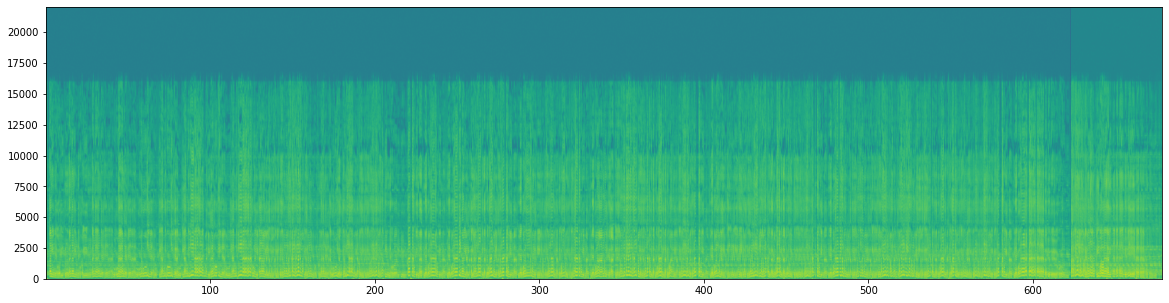

In [ ]:
test_case_3 = [Audio("/content/drive/My Drive/AA/Music dataset/Audio/223582__gopalkoduri__carnatic-varnam-by-vignesh-in-abhogi-raaga.mp3", tonic = 138,songname = "vig_ab"),
               Audio("/content/drive/My Drive/AA/Music dataset/Audio/223580__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-abhogi-raaga.mp3", tonic =149, songname = "rkm_ab"),
               Audio("/content/drive/My Drive/AA/Music dataset/Audio/223578__gopalkoduri__carnatic-varnam-by-dharini-in-abhogi-raaga.mp3", tonic = 200, songname = "dhari_ab"),
               Audio("/content/drive/My Drive/AA/Music dataset/Audio/223588__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-kalyani-raaga.mp3",tonic = 149,songname="rkm_kal"),
               Audio("/content/drive/My Drive/AA/Music dataset/Audio/223589__gopalkoduri__carnatic-varnam-by-vignesh-in-kalyani-raaga.mp3",tonic = 138,songname="vig_kal"),
               Audio("/content/drive/My Drive/AA/Music dataset/Audio/223587__gopalkoduri__carnatic-varnam-by-prasanna-in-kalyani-raaga.mp3",tonic = 147,songname="pra_kal"),
               Audio("/content/drive/My Drive/AA/Music dataset/Audio/223579__gopalkoduri__carnatic-varnam-by-prasanna-in-abhogi-raaga.mp3",tonic = 147,songname="pra_ab"),
               Audio("/content/drive/My Drive/AA/Music dataset/Audio/223581__gopalkoduri__carnatic-varnam-by-sreevidya-in-abhogi-raaga.mp3",tonic = 210,songname="sreevidya_ab"),
               Audio("/content/drive/My Drive/AA/Music dataset/Audio/223583__gopalkoduri__carnatic-varnam-by-prasanna-in-begada-raaga.mp3",tonic = 147,songname="pra_begada"),
               Audio("/content/drive/My Drive/AA/Music dataset/Audio/223584__gopalkoduri__carnatic-varnam-by-sreevidya-in-begada-raaga.mp3",tonic = 210,songname="sreevidya_begada"),
               Audio("/content/drive/My Drive/AA/Music dataset/Audio/223585__gopalkoduri__carnatic-varnam-by-vignesh-in-begada-raaga.mp3",tonic = 138,songname="vignesh_begada"),
               Audio("/content/drive/My Drive/AA/Music dataset/Audio/223586__gopalkoduri__carnatic-varnam-by-badrinarayanan-in-kalyani-raaga.mp3",tonic =138 ,songname="badri_kal"),
               Audio("/content/drive/My Drive/AA/Music dataset/Audio/223590__gopalkoduri__carnatic-varnam-by-badrinarayanan-in-mohanam-raaga.mp3",tonic = 138,songname="badri_mohana"),
               Audio("/content/drive/My Drive/AA/Music dataset/Audio/223591__gopalkoduri__carnatic-varnam-by-dharini-in-mohanam-raaga.mp3",tonic =200 ,songname="dhari_mohana"),
               Audio("/content/drive/My Drive/AA/Music dataset/Audio/223592__gopalkoduri__carnatic-varnam-by-prasanna-in-mohanam-raaga.mp3",tonic = 146,songname="pra_mohana"),
               Audio("/content/drive/My Drive/AA/Music dataset/Audio/223593__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-mohanam-raaga.mp3",tonic = 149  ,songname="rkm_mohana"),
               Audio("/content/drive/My Drive/AA/Music dataset/Audio/223594__gopalkoduri__carnatic-varnam-by-dharini-in-sahana-raaga.mp3",tonic = 200,songname="dhari_saha"),
               Audio("/content/drive/My Drive/AA/Music dataset/Audio/223595__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-sahana-raaga.mp3",tonic = 149,songname="rkm_saha"),
               Audio("/content/drive/My Drive/AA/Music dataset/Audio/223596__gopalkoduri__carnatic-varnam-by-sreevidya-in-sahana-raaga.mp3",tonic =210 ,songname="sreevidya_saha"),
               Audio("/content/drive/My Drive/AA/Music dataset/Audio/223597__gopalkoduri__carnatic-varnam-by-vignesh-in-sahana-raaga.mp3",tonic = 138,songname="vig_saha"),
               Audio("/content/drive/My Drive/AA/Music dataset/Audio/223598__gopalkoduri__carnatic-varnam-by-badrinarayanan-in-saveri-raaga.mp3",tonic = 138 ,songname="badri_saveri"),
               Audio("/content/drive/My Drive/AA/Music dataset/Audio/223599__gopalkoduri__carnatic-varnam-by-dharini-in-saveri-raaga.mp3",tonic = 200,songname="dhari_saveri"),
               Audio("/content/drive/My Drive/AA/Music dataset/Audio/223600__gopalkoduri__carnatic-varnam-by-prasanna-in-saveri-raaga.mp3",tonic = 146,songname="pra_saveri"),
               Audio("/content/drive/My Drive/AA/Music dataset/Audio/223601__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-saveri-raaga.mp3",tonic = 149,songname="rkm_saveri"),
               Audio("/content/drive/My Drive/AA/Music dataset/Audio/223602__gopalkoduri__carnatic-varnam-by-sreevidya-in-saveri-raaga.mp3",tonic = 210,songname="sreevidya_saveri"),
               Audio("/content/drive/My Drive/AA/Music dataset/Audio/223603__gopalkoduri__carnatic-varnam-by-badrinarayanan-in-sri-raaga.mp3",tonic = 138,songname="badri_sri"),
               Audio("/content/drive/My Drive/AA/Music dataset/Audio/223604__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-sri-raaga.mp3",tonic = 149,songname="rkm_sri"),
               Audio("/content/drive/My Drive/AA/Music dataset/Audio/223605__gopalkoduri__carnatic-varnam-by-vignesh-in-sri-raaga.mp3",tonic =138 ,songname="vig_sri")
               ]

# Tonic
## badrinarayanan: 138.59
##dharini: 200.58
## prasanna: 146.83
## ramakrishnamurthy: 149.4
## sreevidya: 210.07
## vignesh: 138.59

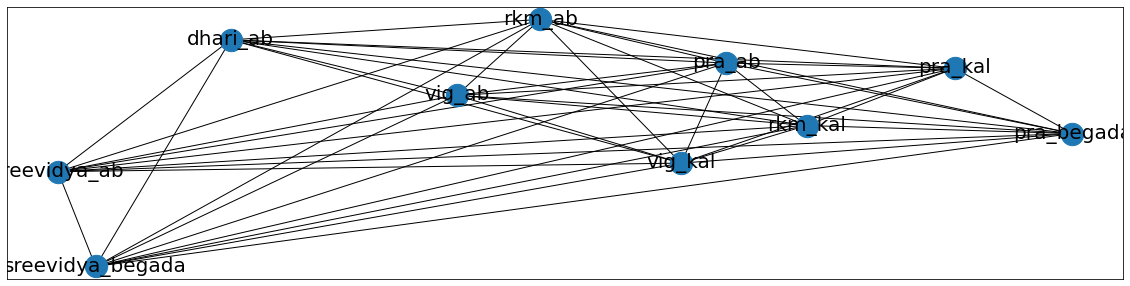

In [ ]:
# temp = [test_case_3[0],test_case_3[1],test_case_3[3],test_case_3[4],test_case_3[5]]
hist,pattern,gamaka2 = validate(test_case_3[0:10])
graph = []
for i,j in hist.items():
  for k in j:
    if i != k and j[k][0]>=0:
      graph.append((i,k,j[k][0]))

import networkx as nx
G = nx.Graph()

G.add_weighted_edges_from(graph)
# G.add_weighted_edges_from([(0, 1, 3.0), (1, 2, 7.5),(2,0,10000)])
pos = nx.spring_layout(G)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=500)

# edges
nx.draw_networkx_edges(G, pos,  width=1)

# labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

# plt.axis("off")
plt.show()


In [ ]:
# rkm_abhogi=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223580__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-abhogi-raaga.mp3')
rkm_kalyani=Audio('/content/drive/My Drive/AA/Music dataset/Audio/223588__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-kalyani-raaga.mp3',tonic = 149)
# rkm_mohana=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223593__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-mohanam-raaga.mp3')
# rkm_sahana=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223595__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-sahana-raaga.mp3')
# rkm_saveri=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223601__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-saveri-raaga.mp3')
# rkm_shree=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223604__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-sri-raaga.mp3')
# badri_kalyani = Audio('/content/drive/My Drive/AA/Music dataset/Audio/223586__gopalkoduri__carnatic-varnam-by-badrinarayanan-in-kalyani-raaga.mp3',tonic=138)
# # badri_mohana = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223590__gopalkoduri__carnatic-varnam-by-badrinarayanan-in-mohanam-raaga.mp3')
# # badri_saveri = Audio("/content/drive/My Drive/Projects/AA/Music dataset/Audio/223598__gopalkoduri__carnatic-varnam-by-badrinarayanan-in-saveri-raaga.mp3")
# # badri_shree = Audio("/content/drive/My Drive/Projects/AA/Music dataset/Audio/223603__gopalkoduri__carnatic-varnam-by-badrinarayanan-in-sri-raaga.mp3")
# prasanna_kalyani = Audio('/content/drive/My Drive/AA/Music dataset/Audio/223587__gopalkoduri__carnatic-varnam-by-prasanna-in-kalyani-raaga.mp3',tonic=146)
# # prasanna_abhogi = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223579__gopalkoduri__carnatic-varnam-by-prasanna-in-abhogi-raaga.mp3')
# # prasanna_begada = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223583__gopalkoduri__carnatic-varnam-by-prasanna-in-begada-raaga.mp3')
# # prasanna_savveri = Audio("/content/drive/My Drive/Projects/AA/Music dataset/Audio/223600__gopalkoduri__carnatic-varnam-by-prasanna-in-saveri-raaga.mp3")
# # prasanna_mohana = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223592__gopalkoduri__carnatic-varnam-by-prasanna-in-mohanam-raaga.mp3')
# vignesh_kalyani= Audio('/content/drive/My Drive/AA/Music dataset/Audio/223589__gopalkoduri__carnatic-varnam-by-vignesh-in-kalyani-raaga.mp3',tonic=138)
# vignesh_abhogi = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223582__gopalkoduri__carnatic-varnam-by-vignesh-in-abhogi-raaga.mp3')
# vignesh_begada = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223585__gopalkoduri__carnatic-varnam-by-vignesh-in-begada-raaga.mp3')
# vignesh_sahana = Audio("/content/drive/My Drive/Projects/AA/Music dataset/Audio/223597__gopalkoduri__carnatic-varnam-by-vignesh-in-sahana-raaga.mp3")
# vignesh_shree = Audio("/content/drive/My Drive/Projects/AA/Music dataset/Audio/223605__gopalkoduri__carnatic-varnam-by-vignesh-in-sri-raaga.mp3")
# dharini_abhogi = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223578__gopalkoduri__carnatic-varnam-by-dharini-in-abhogi-raaga.mp3')
# dharini_sahana = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223594__gopalkoduri__carnatic-varnam-by-dharini-in-sahana-raaga.mp3')
# dharini_mohana = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223591__gopalkoduri__carnatic-varnam-by-dharini-in-mohanam-raaga.mp3')
# dharini_saveri = Audio("/content/drive/My Drive/Projects/AA/Music dataset/Audio/223599__gopalkoduri__carnatic-varnam-by-dharini-in-saveri-raaga.mp3")
# sreeevidya_abhogi = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223581__gopalkoduri__carnatic-varnam-by-sreevidya-in-abhogi-raaga.mp3')
# sreevidya_begada = Audio("/content/drive/My Drive/Projects/AA/Music dataset/Audio/223584__gopalkoduri__carnatic-varnam-by-sreevidya-in-begada-raaga.mp3")
# sreevidya_sahana = Audio("/content/drive/My Drive/Projects/AA/Music dataset/Audio/223596__gopalkoduri__carnatic-varnam-by-sreevidya-in-sahana-raaga.mp3")
# sreevidya_saveri = Audio("/content/drive/My Drive/Projects/AA/Music dataset/Audio/223602__gopalkoduri__carnatic-varnam-by-sreevidya-in-saveri-raaga.mp3")